In [1]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

import keras_uncertainty
from keras_uncertainty.utils import numpy_negative_log_likelihood, numpy_entropy
from keras_uncertainty.layers import DropConnectConv2D, DropConnectDense
from keras_uncertainty.models import MCDropoutClassifier
from keras_uncertainty.utils import numpy_regression_nll

import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [2]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    #print(data_frame.head(10))
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')

x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)




In [4]:

value = 0

InDistribution_Q_Train =  q_train[x_train[0] > value]
OutDistribution_Q_Train = q_train[x_train[0] < value]
InDistribution_X_Train =  x_train[x_train[0] > value]
OutDistribution_X_Train = x_train[x_train[0] < value]

InDistribution_Q_Test =  q_test[x_test[0] > value]
OutDistribution_Q_Test = q_test[x_test[0] < value]
InDistribution_X_Test =  x_test[x_test[0] > value]
OutDistribution_X_Test = x_test[x_test[0] < value]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

In [5]:
print(x_train_1.shape, x_test_1.shape, x_train.shape, x_test.shape)

(5226, 9) (1485, 9) (15625, 9) (4096, 9)


In [6]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [30]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()
        

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(DropConnectDense(num_neurons, activation='relu', input_shape=(input_shape,), prob=0.4))
            else:
                model.add(DropConnectDense(num_neurons, activation='relu', prob=0.4))

            model.add(BatchNormalization())
            #num_neurons= num_neurons + 32
            Flatten()

        model.add(DropConnectDense(output_shape, activation='sigmoid', prob=0.4))
        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [31]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  0.9}
import tensorflow as tf
with tf.device('/cpu:0'):
    model = model_builder(9, 18)(**HYPERPARAMETERS)
    hist = model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))
    model.save("ik-rh5-leg-5steps_dropconnect_OOD.h5")

Train on 5226 samples, validate on 1485 samples
Epoch 1/100
5226/5226 [==============================] - 1s 254us/step - loss: 0.1728 - mae: 0.3408 - val_loss: 0.1078 - val_mae: 0.2853
Epoch 2/100
5226/5226 [==============================] - 0s 38us/step - loss: 0.1546 - mae: 0.3226 - val_loss: 0.1057 - val_mae: 0.2811
Epoch 3/100
5226/5226 [==============================] - 0s 38us/step - loss: 0.1432 - mae: 0.3099 - val_loss: 0.1036 - val_mae: 0.2764
Epoch 4/100
5226/5226 [==============================] - 0s 39us/step - loss: 0.1322 - mae: 0.2978 - val_loss: 0.1024 - val_mae: 0.2735
Epoch 5/100
5226/5226 [==============================] - 0s 40us/step - loss: 0.1203 - mae: 0.2841 - val_loss: 0.1011 - val_mae: 0.2710
Epoch 6/100
5226/5226 [==============================] - 0s 38us/step - loss: 0.1106 - mae: 0.2722 - val_loss: 0.0993 - val_mae: 0.2673
Epoch 7/100
5226/5226 [==============================] - 0s 38us/step - loss: 0.1032 - mae: 0.2628 - val_loss: 0.0962 - val_mae: 0.2615

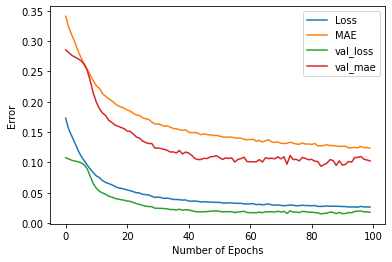

In [32]:
epoch  = list(range(0, 100, 1))
#print(epoch)
#print(hist.history['loss'])
plt.figure()
plt.plot( epoch, hist.history['loss'],     label = 'Loss')
plt.plot( epoch, hist.history['mae'],      label = 'MAE')
plt.plot( epoch, hist.history['val_loss'], label = 'val_loss')
plt.plot( epoch, hist.history['val_mae'],  label = 'val_mae')
plt.xlabel("Number of Epochs")
plt.ylabel("Error")
plt.legend(loc='upper right')


In [33]:
q_pred = model.predict(x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(q_test, q_pred)

print("Testing MAE: {:.5f}".format(global_mae))

# Compute MAE for each output independently.
for i in range(q_test.shape[1]):
    norm_mae_i = mean_absolute_error(q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))



Testing MAE: 0.13163
Q feature 0 has unnorm MAE: 0.3423 (Range -0.7330 to 0.4398) normalized MAE: 0.2918
Q feature 1 has unnorm MAE: 0.3675 (Range -0.3840 to 0.5792) normalized MAE: 0.3815
Q feature 2 has unnorm MAE: 0.1137 (Range -0.8200 to -0.0680) normalized MAE: 0.1512
Q feature 3 has unnorm MAE: 0.1148 (Range -0.8381 to -0.0792) normalized MAE: 0.1513
Q feature 4 has unnorm MAE: 0.0126 (Range 0.0070 to 0.0907) normalized MAE: 0.1507
Q feature 5 has unnorm MAE: 0.0461 (Range 0.0000 to 1.0000) normalized MAE: 0.0461
Q feature 6 has unnorm MAE: 0.0046 (Range -0.0822 to 0.0000) normalized MAE: 0.0565
Q feature 7 has unnorm MAE: 0.0034 (Range 0.0000 to 0.0782) normalized MAE: 0.0440
Q feature 8 has unnorm MAE: 0.1295 (Range -0.7850 to 0.4710) normalized MAE: 0.1031
Q feature 9 has unnorm MAE: 0.1545 (Range -0.7850 to 0.4710) normalized MAE: 0.1230
Q feature 10 has unnorm MAE: 0.1289 (Range -0.5905 to 0.8678) normalized MAE: 0.0884
Q feature 11 has unnorm MAE: 0.1380 (Range -0.5744 to 0

In [34]:
from keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from keras_uncertainty.models import MCDropoutRegressor
from sklearn.preprocessing import MinMaxScaler

def test_mcdropconnect_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    #q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, std

mean_1, std_1 = test_mcdropconnect_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)
    

Testing MAE: 0.30334


In [35]:
mean_test_IOD, sd_test_IOD = test_mcdropconnect_regressor(IOD_x_test, IOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.23652
NLL: 4.66199


In [36]:
mean_test_OOD, sd_test_OOD = test_mcdropconnect_regressor(OOD_x_test, OOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.28563
NLL: 17.38847


In [43]:
col_no = 2

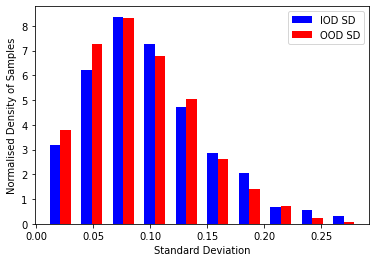

In [44]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))

new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normalised Density of Samples")
fig.savefig("density_vs_sd_dropconnect_neg_split_col_2.pdf")

AUC Score:  0.4638969807870612


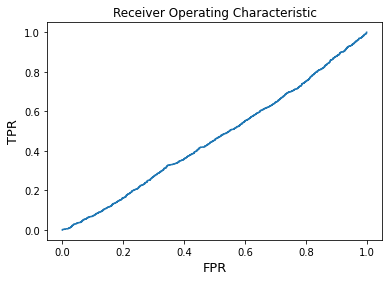

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print("AUC Score: ",auc)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_dropconnect_neg_split_col_2.pdf")
plt.show()
